Imports


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import Embedding, Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [388]:
df = pd.read_csv('/Users/samir/Documents/GitHub/Google-Zero-Day-in-the-Wild-/0day _In the Wild_ - All.csv')

In [389]:
df.head()

,CVE,Vendor,Product,Type,Description,Date Discovered,Date Patched,Advisory,Analysis URL,Root Cause Analysis,Reported By
0,CVE-2024-23296,Apple,iOS,Memory Corruption,Arbitrary kernel r/w in RTKit,NaN,2024-03-06,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
1,CVE-2024-23225,Apple,iOS,Memory Corruption,Out-of-bounds memory access in Kernel,NaN,2024-03-05,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
2,CVE-2024-23222,Apple,WebKit,Memory Corruption,Type confusion,NaN,2024-01-22,https://support.apple.com/en-us/HT214059,NaN,NaN,NaN
3,CVE-2024-0519,Google,Chrome,Memory Corruption,Out-of-bounds memory access,2024-01-11,2024-01-16,https://chromereleases.googleblog.com/2024/01/...,NaN,NaN,NaN
4,CVE-2023-7024,Google,Chrome,Memory Corruption,Heap overflow in WebRTC,2023-12-19,2023-12-20,https://chromereleases.googleblog.com/2023/12/...,NaN,NaN,Clément Lecigne and Vlad Stolyarov of Google's...


Top 5 most Zero-Day according to Companies.

In [390]:
df.isna().sum()

CVE                      0
Vendor                   0
Product                  0
Type                     4
Description              0
Date Discovered        188
Date Patched             0
Advisory                 0
Analysis URL           139
Root Cause Analysis    245
Reported By             92
dtype: int64

In [391]:
df['Date Patched'] = pd.to_datetime(df['Date Patched'])


In [392]:
# Handling Missing Data
df['Description'].fillna('Unknown')
df['Vendor'].fillna('Unknown')
df['Product'].fillna('Unknown')
df['Type'].fillna('Unknown')
df.isna().sum()

CVE                      0
Vendor                   0
Product                  0
Type                     4
Description              0
Date Discovered        188
Date Patched             0
Advisory                 0
Analysis URL           139
Root Cause Analysis    245
Reported By             92
dtype: int64

In [393]:
df_cleaned = df.drop(columns=['Date Discovered', 'Date Patched','Analysis URL', 'Root Cause Analysis', 'Reported By'])
df_cleaned.head()

,CVE,Vendor,Product,Type,Description,Advisory
0,CVE-2024-23296,Apple,iOS,Memory Corruption,Arbitrary kernel r/w in RTKit,https://support.apple.com/en-gb/HT214081
1,CVE-2024-23225,Apple,iOS,Memory Corruption,Out-of-bounds memory access in Kernel,https://support.apple.com/en-gb/HT214081
2,CVE-2024-23222,Apple,WebKit,Memory Corruption,Type confusion,https://support.apple.com/en-us/HT214059
3,CVE-2024-0519,Google,Chrome,Memory Corruption,Out-of-bounds memory access,https://chromereleases.googleblog.com/2024/01/...
4,CVE-2023-7024,Google,Chrome,Memory Corruption,Heap overflow in WebRTC,https://chromereleases.googleblog.com/2023/12/...


The types of Zero-Day Exploitation.

In [394]:
df_cleaned['Type'].value_counts()


Type
Memory Corruption    220
Logic/Design Flaw     63
Information Leak      11
Use-after-free         6
XSS                    2
UXSS                   2
Info disclosure        1
Unspecified            1
Type Confusion         1
Race Condition         1
Name: count, dtype: int64

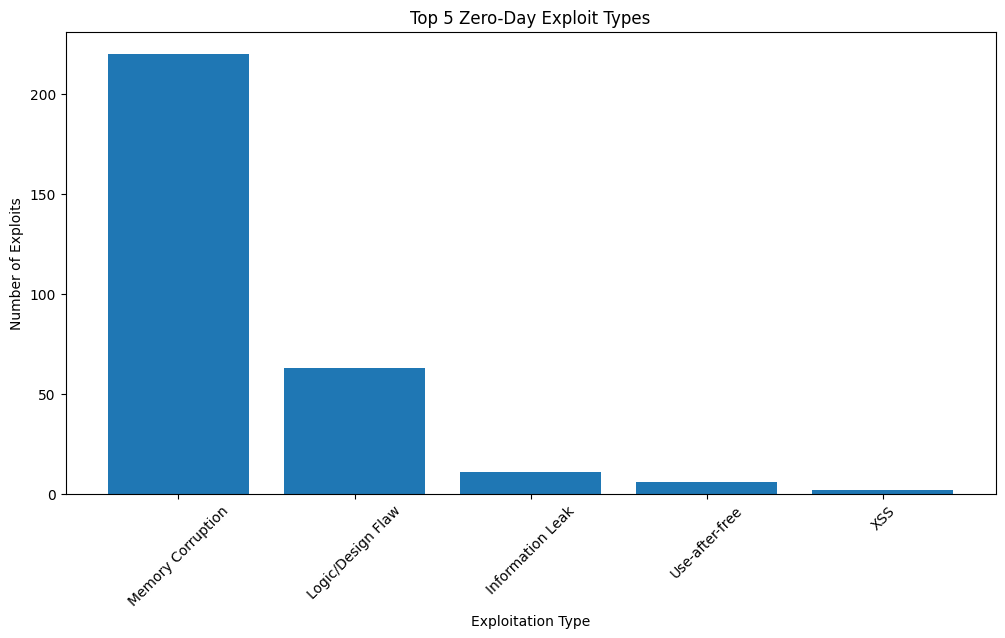

In [395]:
values = df_cleaned['Type'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(values[:5].index, values[:5])
plt.xlabel('Exploitation Type', loc='center')
plt.ylabel('Number of Exploits')
plt.xticks(rotation=45)
plt.title('Top 5 Zero-Day Exploit Types')
plt.show()

Classification based on the Exploitation type.


In [396]:
df_cleaned = pd.get_dummies(df_cleaned, columns=[ 'Product'], drop_first=True)
label_encoder = LabelEncoder()
df_cleaned['CVE_encoded'] = label_encoder.fit_transform(df_cleaned['CVE'])
df_cleaned['Vendor'] = label_encoder.fit_transform(df_cleaned['Vendor'])


In [397]:
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(df['Description'])
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [398]:
# Combining processed data
df_combined = pd.concat([df_cleaned, X_tfidf_df], axis=1)

In [399]:
X = df_combined.drop(columns=['CVE','Vendor','Description', 'Type', 'Advisory'])
y = label_encoder.fit_transform(df_combined['Type'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('CVE_encoded' in X_train.columns)

True


In [400]:
X_test_scaled = np.array(X_test.drop(columns=['CVE_encoded']))
X_train_scaled = np.array(X_train.drop(columns=['CVE_encoded']))

X_test_cve = np.array(X_test['CVE_encoded'])
X_train_cve = np.array(X_train['CVE_encoded'])



In [401]:
#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Building the Model

In [402]:
#Model Building with Embedding for 'CVE'
input_dim = df_cleaned['CVE_encoded'].nunique()
embedding_dim = 50
#Neural Network with Embedding for CVE

input_cve = keras.Input(shape=(1,))
embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=1)(input_cve)
embedding_flatten = keras.layers.Flatten()(embedding_layer)


/Users/samir/anaconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [403]:
#Input for the remaining features
input_features = keras.Input(shape=(X_train_scaled.shape[1],))
combined = keras.layers.concatenate([embedding_flatten, input_features])

In [404]:
x = Dense(128, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(np.unique(y)), activation='softmax')(x)


In [405]:
model = keras.Model(inputs=[input_cve, input_features], outputs=output)

Compiling the Model.

In [406]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Training the model

In [486]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=0.2, min_lr=0.001)


In [495]:
trained_model = model.fit([X_train_cve,X_train_scaled], y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
loss, accuracy = model.evaluate([X_test_cve,X_test_scaled], y_test)

print(f'Test Accuracy: {accuracy}')

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 2.7681e-04 - learning_rate: 0.0010
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 3.6285e-04 - learning_rate: 0.0010
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4818e-04 - val_accuracy: 1.0000 - val_loss: 5.3535e-04 - learning_rate: 0.0010
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.3679e-04 - val_accuracy: 1.0000 - val_loss: 6.5149e-04 - learning_rate: 0.0010
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 7.4767e-04 - learning_rate: 0.0010
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.0512e-04 - val_accuracy: 1.0000 - val_loss: 8.6018e-04 - learning_rate: 0.0010
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1

Making predictions

In [496]:
predictions = model.predict([X_test_cve, X_test_scaled])
predicted_classes = tf.argmax(predictions, axis=1)
predicted_classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<tf.Tensor: shape=(63,), dtype=int64, numpy=
array([2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 0, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3])>

In [497]:
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy}')

Accuracy: 0.873015873015873


Confusion Matrix

In [498]:
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(f'Confusion Matrix:\n{conf_matrix}\n')
class_report = classification_report(y_test, predicted_classes)
print(f'Classification Report:\n{class_report}')

Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [ 0  2  0  1  0  0  0]
 [ 0  0  7  1  0  0  0]
 [ 1  0  2 46  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.80         3
           2       0.78      0.88      0.82         8
           3       0.90      0.94      0.92        49
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.87        63
   macro avg       0.38      0.35      0.36        63
weighted avg       0.85      0.87      0.86        63



/Users/samir/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samir/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samir/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

Plotting the Confusion Matrix

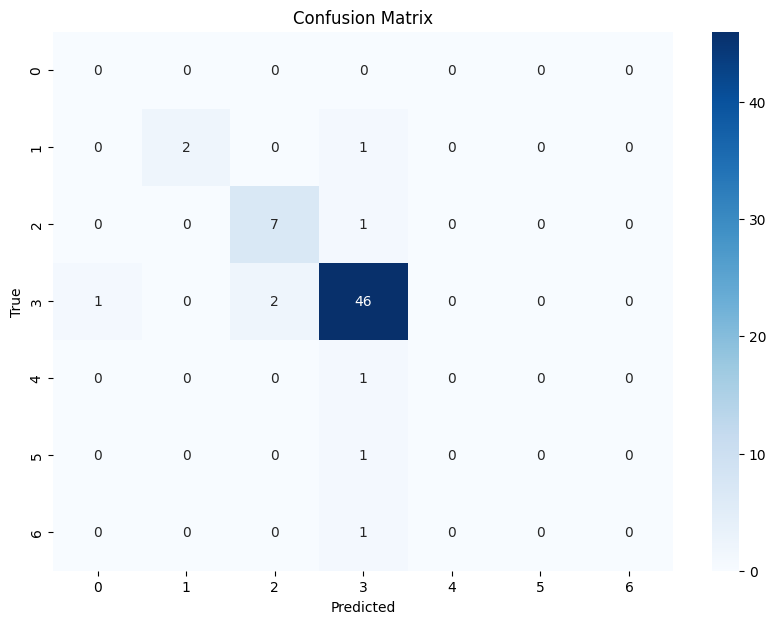

In [499]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()